In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_05_01_29
NN-MODEL FILENAME:  ./models/VBKG0BIX_05_01_29_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 6
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  6


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 71438.23 MiB, increment: 65436.24 MiB
Quantization TIME:  0.59 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   41138
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 136
TOTAL SERIAL TIMESTEPS:   41138
TOTAL PARALLEL TIMESTEPS: 136


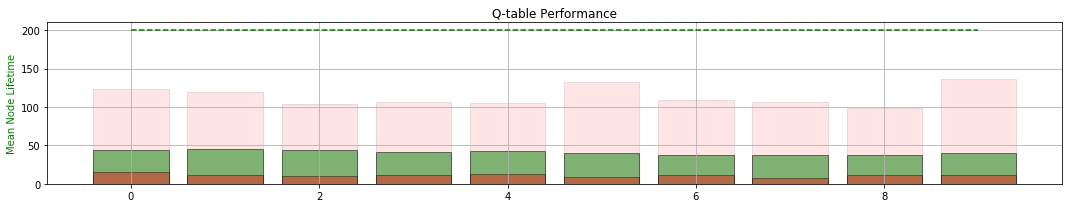

MEMORY COUNTER:  41138
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 227.457	LOSS : 243.786	LOSS : 224.188	LOSS : 227.784	LOSS : 231.425	LOSS : 219.961	LOSS : 221.963	LOSS : 237.190	LOSS : 217.442	LOSS : 220.217	LOSS : 207.353	LOSS : 213.049	LOSS : 213.783	LOSS : 205.029	LOSS : 208.293	LOSS : 205.241	LOSS : 209.136	LOSS : 205.423	LOSS : 219.681	LOSS : 203.819	
Validating... MEAN TIME:  200.0
LOSS : 228.665	LOSS : 198.373	LOSS : 207.900	LOSS : 210.190	LOSS : 212.051	LOSS : 213.074	LOSS : 209.083	LOSS : 200.528	LOSS : 211.126	LOSS : 207.976	LOSS : 196.846	LOSS : 220.143	LOSS : 209.332	LOSS : 196.251	LOSS : 187.818	LOSS : 207.331	LOSS : 205.245	LOSS : 203.085	LOSS : 210.228	LOSS : 192.878	
Validating... MEAN TIME:  193.385
LOSS : 209.329	LOSS : 206.908	LOSS : 200.830	LOSS : 207.160	LOSS : 197.541	LOSS : 200.359	LOSS : 194.778	LOSS : 207.256	LOSS : 217.170	LOSS : 196.514	LOSS : 203.801	LOSS : 205.088	LOSS : 193.887	LOSS : 211.783	LOSS : 208.385	LOSS : 201.891	LOSS : 184

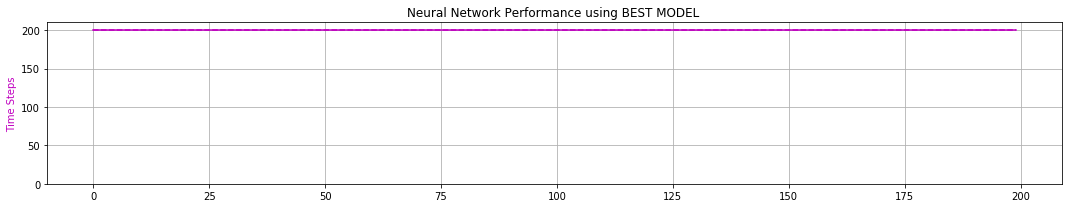

peak memory: 72272.39 MiB, increment: 65056.82 MiB
0 -max- [ 0.874  1.863  0.208  1.727  0.275]
0 -min- [-0.693 -1.354 -0.209 -2.044  0.225]

1 -max- [ 1.036  1.863  0.208  2.127  0.325]
1 -min- [-0.862 -1.510 -0.209 -2.196  0.275]

2 -max- [ 1.107  2.437  0.209  2.223  0.375]
2 -min- [-0.731 -1.477 -0.209 -2.260  0.325]

3 -max- [ 1.006  2.026  0.209  1.704  0.424]
3 -min- [-1.046 -1.868 -0.209 -2.122  0.375]

4 -max- [ 1.888  3.188  0.209  1.687  0.474]
4 -min- [-0.496 -1.521 -0.209 -2.249  0.425]

5 -max- [ 0.983  2.301  0.209  2.127  0.525]
5 -min- [-0.676 -1.395 -0.209 -2.132  0.477]

6 -max- [ 1.250  2.663  0.208  1.835  0.574]
6 -min- [-1.307 -1.829 -0.209 -2.230  0.525]

7 -max- [ 1.385  2.319  0.208  2.026  0.625]
7 -min- [-0.475 -1.765 -0.209 -2.299  0.576]

8 -max- [ 0.927  2.048  0.209  1.981  0.675]
8 -min- [-0.381 -1.310 -0.209 -2.203  0.625]

9 -max- [ 1.233  2.139  0.208  1.968  0.725]
9 -min- [-0.258 -1.144 -0.209 -2.238  0.675]

Quantization TIME:  0.59 minutes


ITER

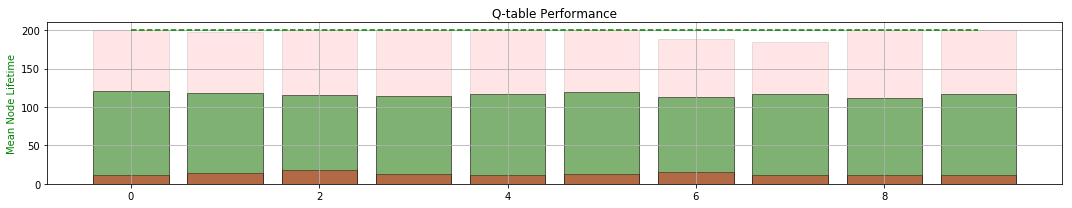

MEMORY COUNTER:  157480
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 130.215	LOSS : 121.248	LOSS : 117.879	LOSS : 114.041	LOSS : 114.717	LOSS : 119.850	LOSS : 124.452	LOSS : 117.473	LOSS : 114.334	LOSS : 114.833	LOSS : 111.014	LOSS : 110.163	LOSS : 109.973	LOSS : 118.068	LOSS : 111.214	LOSS : 103.787	LOSS : 112.543	LOSS : 106.933	LOSS : 102.453	LOSS : 117.214	
Validating... MEAN TIME:  144.38
LOSS : 113.555	LOSS : 112.995	LOSS : 123.092	LOSS : 120.760	LOSS : 128.991	LOSS : 115.218	LOSS : 125.706	LOSS : 101.693	LOSS : 115.876	LOSS : 109.565	LOSS : 113.258	LOSS : 107.550	LOSS : 108.890	LOSS : 113.880	LOSS : 115.210	LOSS : 120.508	LOSS : 116.158	LOSS : 116.536	LOSS : 114.707	LOSS : 106.898	
Validating... MEAN TIME:  171.82
LOSS : 102.736	LOSS : 115.756	LOSS : 120.287	LOSS : 110.579	LOSS : 110.493	LOSS : 121.530	LOSS : 108.948	LOSS : 120.172	LOSS : 109.734	LOSS : 116.638	LOSS : 111.053	LOSS : 110.355	LOSS : 107.194	LOSS : 113.479	LOSS : 117.362	LOSS : 111.993	LOSS : 11

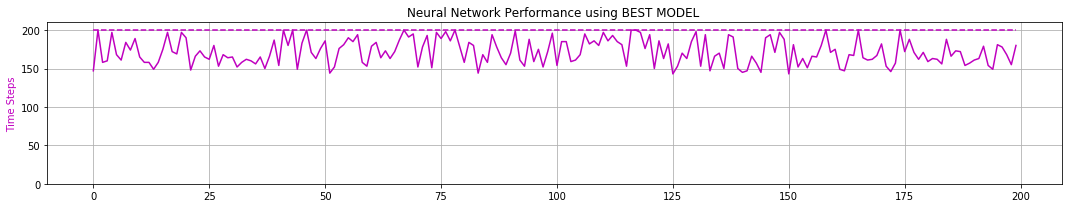

peak memory: 73396.79 MiB, increment: 64971.45 MiB
0 -max- [ 0.784  1.912  0.208  1.810  0.275]
0 -min- [-2.400 -2.840 -0.209 -2.279  0.226]

1 -max- [ 0.174  1.010  0.203  1.588  0.325]
1 -min- [-2.398 -2.637 -0.209 -2.129  0.275]

2 -max- [ 0.351  1.186  0.209  1.841  0.375]
2 -min- [-2.398 -2.827 -0.209 -1.949  0.325]

3 -max- [ 0.420  1.542  0.209  1.655  0.424]
3 -min- [-2.399 -2.800 -0.209 -1.924  0.375]

4 -max- [ 0.470  1.332  0.208  1.941  0.475]
4 -min- [-2.400 -2.631 -0.208 -1.875  0.425]

5 -max- [ 0.405  1.155  0.208  1.985  0.525]
5 -min- [-2.400 -2.773 -0.209 -1.839  0.475]

6 -max- [ 0.319  0.964  0.196  1.751  0.575]
6 -min- [-2.400 -2.943 -0.209 -2.207  0.526]

7 -max- [ 0.161  1.138  0.208  1.598  0.624]
7 -min- [-2.400 -2.769 -0.209 -2.244  0.576]

8 -max- [ 0.310  1.164  0.206  1.844  0.675]
8 -min- [-2.400 -2.784 -0.209 -1.780  0.626]

9 -max- [ 0.365  1.180  0.207  1.610  0.724]
9 -min- [-2.400 -2.992 -0.209 -2.081  0.675]

Quantization TIME:  0.58 minutes


ITER

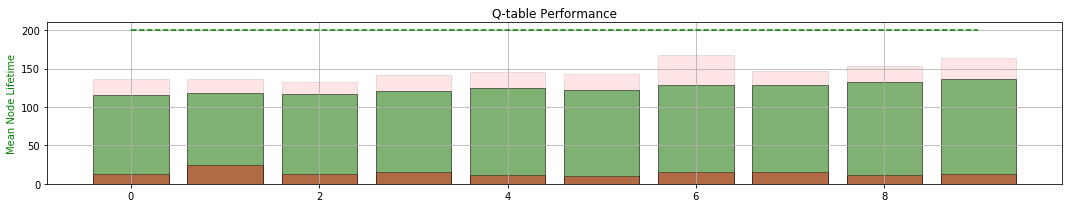

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 94.076	LOSS : 80.116	LOSS : 81.494	LOSS : 71.975	LOSS : 77.264	LOSS : 78.248	LOSS : 80.362	LOSS : 77.715	LOSS : 76.409	LOSS : 69.944	LOSS : 74.089	LOSS : 77.518	LOSS : 83.550	LOSS : 75.933	LOSS : 67.940	LOSS : 76.518	LOSS : 71.378	LOSS : 76.873	LOSS : 81.238	LOSS : 73.171	
Validating... MEAN TIME:  129.2
LOSS : 82.610	LOSS : 77.974	LOSS : 77.978	LOSS : 85.789	LOSS : 77.163	LOSS : 81.182	LOSS : 69.470	LOSS : 70.628	LOSS : 77.923	LOSS : 79.478	LOSS : 77.607	LOSS : 88.360	LOSS : 76.004	LOSS : 75.992	LOSS : 78.347	LOSS : 90.897	LOSS : 71.313	LOSS : 77.887	LOSS : 79.414	LOSS : 75.241	
Validating... MEAN TIME:  182.955
LOSS : 75.714	LOSS : 71.156	LOSS : 69.858	LOSS : 74.800	LOSS : 77.520	LOSS : 68.318	LOSS : 73.745	LOSS : 71.870	LOSS : 80.268	LOSS : 79.549	LOSS : 71.168	LOSS : 65.734	LOSS : 74.100	LOSS : 65.297	LOSS : 73.036	LOSS : 73.471	LOSS : 81.189	LOSS : 67.384	LOSS : 76.009	LOSS : 84.792	
Validati

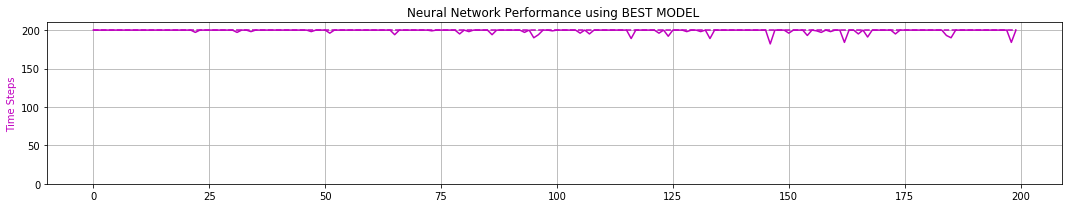

peak memory: 73827.83 MiB, increment: 65368.12 MiB
0 -max- [ 0.190  1.166  0.048  1.220  0.275]
0 -min- [-2.399 -2.786 -0.209 -1.872  0.225]

1 -max- [ 0.178  1.009  0.093  1.195  0.325]
1 -min- [-2.399 -2.595 -0.207 -1.489  0.279]

2 -max- [ 0.161  1.184  0.047  1.446  0.375]
2 -min- [-2.400 -3.125 -0.209 -1.934  0.326]

3 -max- [ 0.176  1.009  0.057  1.383  0.425]
3 -min- [-2.399 -2.735 -0.208 -1.545  0.375]

4 -max- [ 0.179  1.160  0.052  1.191  0.475]
4 -min- [-2.399 -2.614 -0.209 -1.745  0.425]

5 -max- [ 0.163  1.176  0.054  1.154  0.525]
5 -min- [-2.400 -2.609 -0.207 -1.716  0.476]

6 -max- [ 0.155  0.994  0.106  1.302  0.575]
6 -min- [-2.400 -2.429 -0.209 -1.541  0.526]

7 -max- [ 0.178  1.009  0.051  1.258  0.624]
7 -min- [-2.399 -2.552 -0.209 -1.546  0.576]

8 -max- [ 0.158  0.997  0.085  1.167  0.675]
8 -min- [-2.400 -2.589 -0.209 -1.502  0.625]

9 -max- [ 0.169  1.013  0.064  1.091  0.725]
9 -min- [-2.400 -2.407 -0.205 -1.590  0.675]

Quantization TIME:  0.59 minutes


ITER

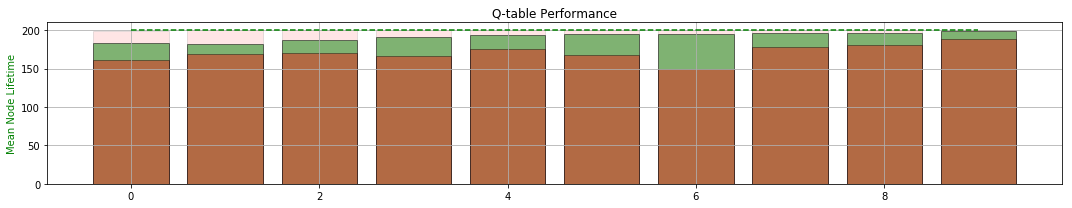

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 54.198	LOSS : 60.442	LOSS : 56.038	LOSS : 43.744	LOSS : 46.810	LOSS : 46.816	LOSS : 54.928	LOSS : 52.548	LOSS : 59.172	LOSS : 49.427	LOSS : 46.933	LOSS : 58.232	LOSS : 51.601	LOSS : 53.096	LOSS : 50.185	LOSS : 44.535	LOSS : 44.399	LOSS : 45.251	LOSS : 48.023	LOSS : 63.199	
Validating... MEAN TIME:  184.49
LOSS : 47.854	LOSS : 51.184	LOSS : 53.098	LOSS : 57.786	LOSS : 43.471	LOSS : 48.124	LOSS : 57.000	LOSS : 56.649	LOSS : 45.833	LOSS : 47.476	LOSS : 55.037	LOSS : 52.573	LOSS : 43.104	LOSS : 51.109	LOSS : 50.147	LOSS : 44.309	LOSS : 45.164	LOSS : 44.008	LOSS : 51.296	LOSS : 57.313	
Validating... MEAN TIME:  155.765
LOSS : 52.987	LOSS : 45.530	LOSS : 52.856	LOSS : 51.159	LOSS : 52.087	LOSS : 60.700	LOSS : 52.527	LOSS : 42.860	LOSS : 41.894	LOSS : 51.442	LOSS : 58.800	LOSS : 50.770	LOSS : 53.028	LOSS : 45.138	LOSS : 47.191	LOSS : 57.391	LOSS : 52.003	LOSS : 42.980	LOSS : 54.242	LOSS : 52.112	
Validat

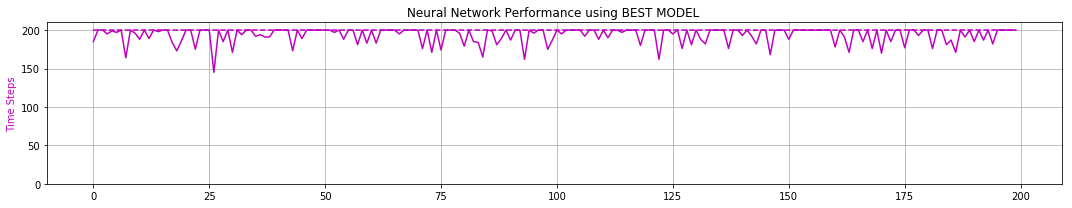

peak memory: 73706.55 MiB, increment: 65208.93 MiB
0 -max- [ 0.176  0.965  0.050  1.114  0.275]
0 -min- [-2.400 -2.425 -0.209 -1.408  0.226]

1 -max- [ 0.112  0.825  0.047  1.185  0.325]
1 -min- [-2.399 -2.373 -0.209 -1.240  0.276]

2 -max- [ 0.146  1.009  0.049  1.164  0.374]
2 -min- [-2.400 -2.361 -0.209 -1.403  0.326]

3 -max- [ 0.152  0.998  0.048  1.186  0.423]
3 -min- [-2.399 -2.337 -0.208 -1.430  0.375]

4 -max- [ 0.116  0.826  0.046  1.338  0.474]
4 -min- [-2.400 -2.383 -0.207 -1.298  0.425]

5 -max- [ 0.110  1.018  0.048  1.002  0.525]
5 -min- [-2.400 -2.215 -0.203 -1.456  0.475]

6 -max- [ 0.119  1.143  0.051  1.397  0.574]
6 -min- [-2.399 -2.202 -0.203 -1.638  0.525]

7 -max- [ 0.113  0.824  0.050  1.040  0.625]
7 -min- [-2.399 -2.241 -0.199 -1.395  0.575]

8 -max- [ 0.122  0.990  0.049  1.080  0.674]
8 -min- [-2.400 -2.169 -0.198 -1.451  0.626]

9 -max- [ 0.134  1.022  0.054  1.180  0.723]
9 -min- [-2.396 -2.153 -0.201 -1.463  0.675]

Quantization TIME:  0.59 minutes


ITER

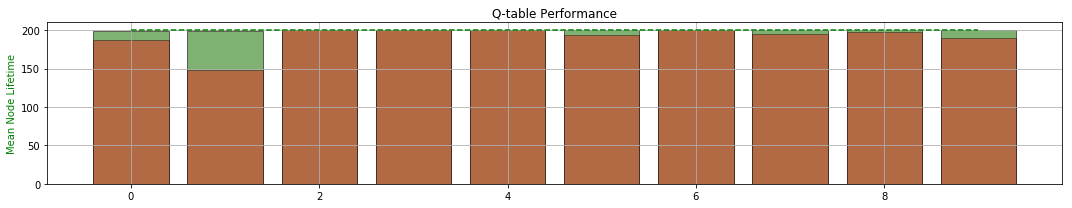

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  904.0
Total Serial Timesteps   :  673317.0
Speed-up                 :  744.82


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 148   4     904     673317     744.82
